# 🛍️ Black Friday Sales — Data Cleaning, EDA & Purchase Prediction

## Project Overview
Black Friday is one of the biggest retail events of the year. This project uses a real-world retail dataset containing **550,000+ transaction records** to:
- Clean and preprocess raw data for analysis
- Explore purchasing patterns across demographics
- Build and compare regression models to predict purchase amounts

## Dataset
- **Source:** Kaggle — Black Friday Sales Dataset  
- **Train set:** ~550,068 rows | **Test set:** ~233,599 rows  
- **Features:** User demographics (Age, Gender, Occupation, City), Product categories, Purchase amount  

## Key Questions
1. Which demographic groups spend the most on Black Friday?  
2. How do product categories influence purchase amounts?  
3. Which machine learning model best predicts purchase value?

## 1. Setup & Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme(style='whitegrid')
matplotlib.rcParams['figure.figsize'] = (14, 5)

## 2. Load Data

In [5]:
# Load train and test datasets
df_train = pd.read_csv('./black_fri_dataset/train.csv')
df_test  = pd.read_csv('./black_fri_dataset/test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape : {df_test.shape}")
df_train.head()

Train shape: (550068, 12)
Test shape : (233599, 11)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [6]:
# Merge train and test for unified cleaning
# Purchase will be NaN for test rows — handled later
df = pd.concat([df_train, df_test], ignore_index=True)
print(f"Merged shape: {df.shape}")

Merged shape: (783667, 12)


## 3. Initial Exploration

In [7]:
# Dataset info — dtypes, non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783667 entries, 0 to 783666
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     783667 non-null  int64  
 1   Product_ID                  783667 non-null  object 
 2   Gender                      783667 non-null  object 
 3   Age                         783667 non-null  object 
 4   Occupation                  783667 non-null  int64  
 5   City_Category               783667 non-null  object 
 6   Stay_In_Current_City_Years  783667 non-null  object 
 7   Marital_Status              783667 non-null  int64  
 8   Product_Category_1          783667 non-null  int64  
 9   Product_Category_2          537685 non-null  float64
 10  Product_Category_3          237858 non-null  float64
 11  Purchase                    550068 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 71.7+ MB


In [8]:
# Statistical summary of numeric columns
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,7.836670e+05,783667.000000,783667.000000,783667.000000,537685.000000,237858.000000,550068.000000
mean,1.003029e+06,8.079300,0.409777,5.366196,9.844506,12.668605,9263.968713
std,1.727267e+03,6.522206,0.491793,3.878160,5.089093,4.125510,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001519e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003075e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


## 4. Data Cleaning

### 4.1 Drop Irrelevant Columns
`User_ID` is a unique identifier with no predictive value — we drop it.

In [9]:
df = df.drop(columns=['User_ID'])
print("Dropped User_ID. Remaining columns:", df.columns.tolist())

Dropped User_ID. Remaining columns: ['Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase']


### 4.2 Encode Gender
`Gender` is binary (M/F) — mapped to 1/0 for modelling.

In [10]:
print("Gender distribution before encoding:")
print(df['Gender'].value_counts())

df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})
print("\nEncoding complete. Sample:")
df[['Gender']].head(3)

Gender distribution before encoding:
Gender
M    590031
F    193636
Name: count, dtype: int64

Encoding complete. Sample:


,Gender
0,0
1,0
2,0


### 4.3 Ordinal Encode Age
Age is stored as string ranges. We map them to ordered integers to preserve the natural ordering.

In [11]:
print("Unique age groups:", df['Age'].unique())

age_map = {'0-17': 1, '18-25': 2, '26-35': 3, '36-45': 4, '46-50': 5, '51-55': 6, '55+': 7}
df['Age'] = df['Age'].map(age_map)
print("Age encoding complete.")

Unique age groups: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Age encoding complete.


### 4.4 One-Hot Encode City Category
`City_Category` (A, B, C) is nominal — we use one-hot encoding, dropping one dummy to avoid multicollinearity.

In [12]:
df_city = pd.get_dummies(df['City_Category'], drop_first=True).astype(int)
df = pd.concat([df, df_city], axis=1)
df = df.drop(columns=['City_Category'])
print("City_Category encoded. New columns added: B, C")
df.head(2)

City_Category encoded. New columns added: B, C


,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,B,C
0,P00069042,0,1,10,2,0,3,NaN,NaN,8370.0,0,0
1,P00248942,0,1,10,2,0,1,6.0,14.0,15200.0,0,0


### 4.5 Fix Stay_In_Current_City_Years
This column contains `'4+'` as a string. We strip the `+` and convert to integer.

In [13]:
print("Unique values before fix:", df['Stay_In_Current_City_Years'].unique())

df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].str.replace('+', '', regex=False).astype(int)
print("Unique values after fix:", df['Stay_In_Current_City_Years'].unique())

Unique values before fix: ['2' '4+' '3' '1' '0']
Unique values after fix: [2 4 3 1 0]


### 4.6 Handle Missing Values
Let's check what's missing.

In [14]:
missing = df.isnull().sum()
missing = missing[missing > 0]
print("Columns with missing values:")
print(missing)
print()
for col in missing.index:
    pct = missing[col] / len(df) * 100
    print(f"  {col}: {missing[col]:,} missing ({pct:.1f}%)")

Columns with missing values:
Product_Category_2    245982
Product_Category_3    545809
Purchase              233599
dtype: int64

  Product_Category_2: 245,982 missing (31.4%)
  Product_Category_3: 545,809 missing (69.6%)
  Purchase: 233,599 missing (29.8%)


**Strategy:**  
- `Product_Category_2` (~31% missing): Filled with **mode** — most rows share the same dominant category.  
- `Product_Category_3` (~69% missing): Also filled with mode. The high missingness reflects that many products simply don't have a third category — treating them as the modal category is a reasonable baseline approach.  
- `Purchase`: Missing only in test rows (by design) — left as-is; these are our prediction targets.

In [15]:
# Fill Product_Category_2
mode_pc2 = df['Product_Category_2'].mode()[0]
df['Product_Category_2'] = df['Product_Category_2'].fillna(mode_pc2)
print(f"Product_Category_2 filled with mode: {mode_pc2}")

# Fill Product_Category_3
mode_pc3 = df['Product_Category_3'].mode()[0]
df['Product_Category_3'] = df['Product_Category_3'].fillna(mode_pc3)
print(f"Product_Category_3 filled with mode: {mode_pc3}")

# Confirm remaining nulls
remaining = df.isnull().sum()
remaining = remaining[remaining > 0]
print(f"\nRemaining nulls (expected only Purchase):")
print(remaining)

Product_Category_2 filled with mode: 8.0
Product_Category_3 filled with mode: 16.0

Remaining nulls (expected only Purchase):
Purchase    233599
dtype: int64


### 4.7 Final Cleaned Dataset

In [16]:
print("Final dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
df.head()

Final dataset shape: (783667, 12)

Data types:
Product_ID                     object
Gender                          int64
Age                             int64
Occupation                      int64
Stay_In_Current_City_Years      int64
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                      float64
B                               int64
C                               int64
dtype: object


,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,B,C
0,P00069042,0,1,10,2,0,3,8.0,16.0,8370.0,0,0
1,P00248942,0,1,10,2,0,1,6.0,14.0,15200.0,0,0
2,P00087842,0,1,10,2,0,12,8.0,16.0,1422.0,0,0
3,P00085442,0,1,10,2,0,12,14.0,16.0,1057.0,0,0
4,P00285442,1,7,16,4,0,8,8.0,16.0,7969.0,0,1


## 5. Exploratory Data Analysis

### 5.1 Age vs. Purchase Amount by Gender

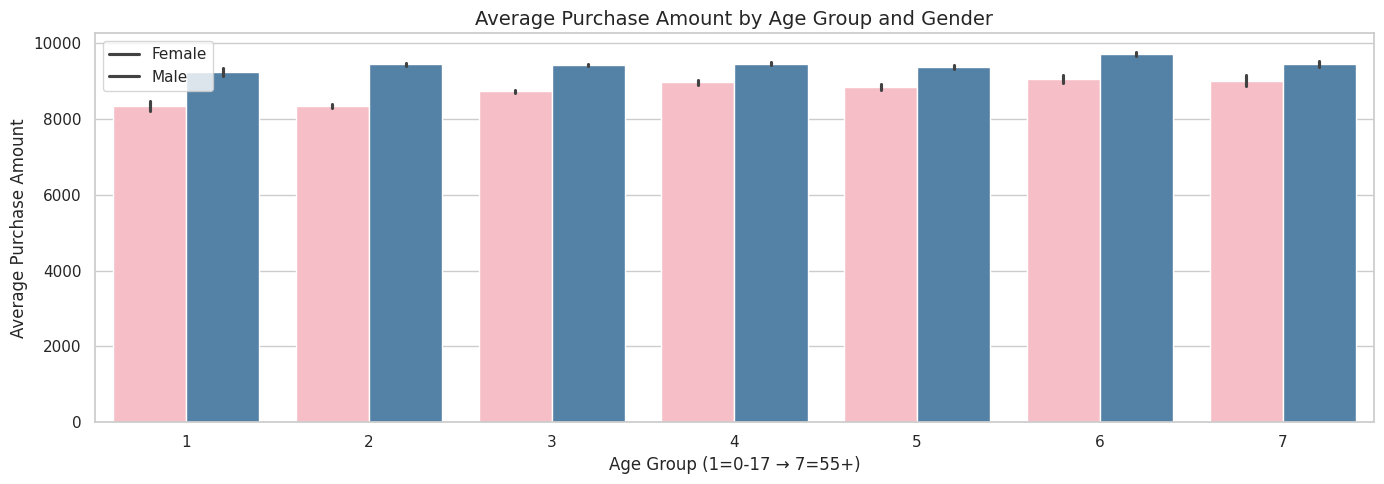

In [17]:
gender_palette = ['lightpink', 'steelblue']
matplotlib.rcParams['figure.figsize'] = (14, 5)

sns.barplot(data=df, x='Age', y='Purchase', hue='Gender', palette=gender_palette)
plt.title('Average Purchase Amount by Age Group and Gender', fontsize=14)
plt.xlabel('Age Group (1=0-17 → 7=55+)')
plt.ylabel('Average Purchase Amount')
plt.legend(labels=['Female', 'Male'])
plt.tight_layout()
plt.show()

**Observation:** Male customers consistently spend more than female customers across all age groups. The 26–35 age group (encoded as 3) shows the highest average purchase, aligning with peak earning years.

### 5.2 Occupation vs. Purchase Amount

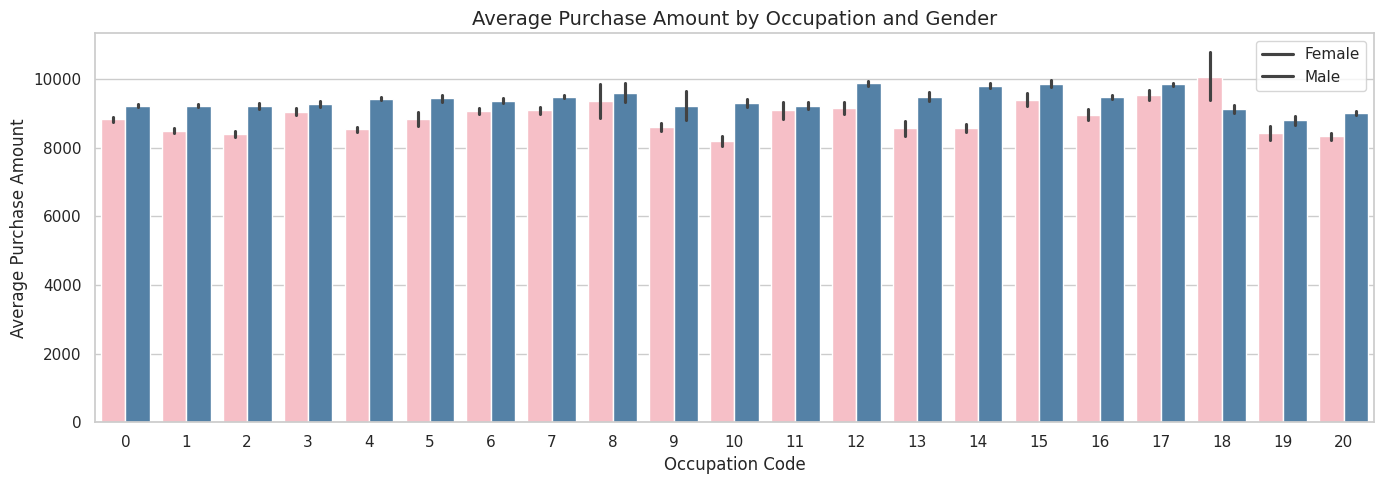

In [18]:
sns.barplot(x='Occupation', y='Purchase', hue='Gender', data=df, palette=gender_palette)
plt.title('Average Purchase Amount by Occupation and Gender', fontsize=14)
plt.xlabel('Occupation Code')
plt.ylabel('Average Purchase Amount')
plt.legend(labels=['Female', 'Male'])
plt.tight_layout()
plt.show()

**Observation:** Purchase amounts are fairly consistent across occupations, suggesting occupation alone is not a strong differentiator. The gender gap persists across all occupation codes.

### 5.3 Product Category 1 vs. Purchase

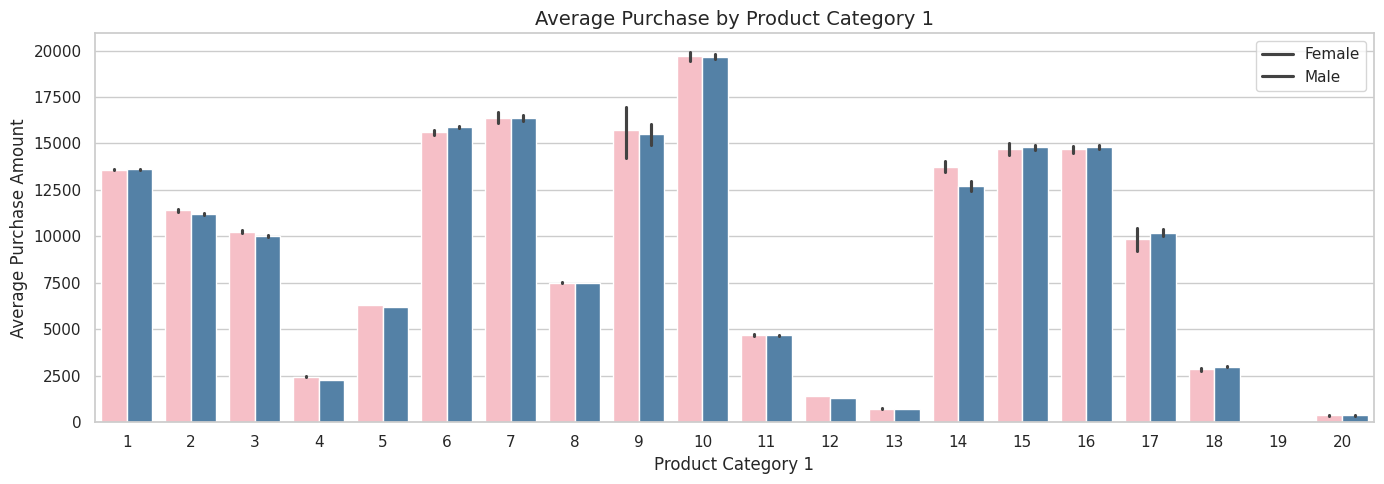

In [19]:
sns.barplot(x='Product_Category_1', y='Purchase', hue='Gender', palette=gender_palette, data=df)
plt.title('Average Purchase by Product Category 1', fontsize=14)
plt.xlabel('Product Category 1')
plt.ylabel('Average Purchase Amount')
plt.legend(labels=['Female', 'Male'])
plt.tight_layout()
plt.show()

**Observation:** Certain product categories (e.g., 1, 7, 10) command significantly higher average purchase amounts, suggesting high-value product segments.

### 5.4 Product Category 2 vs. Purchase

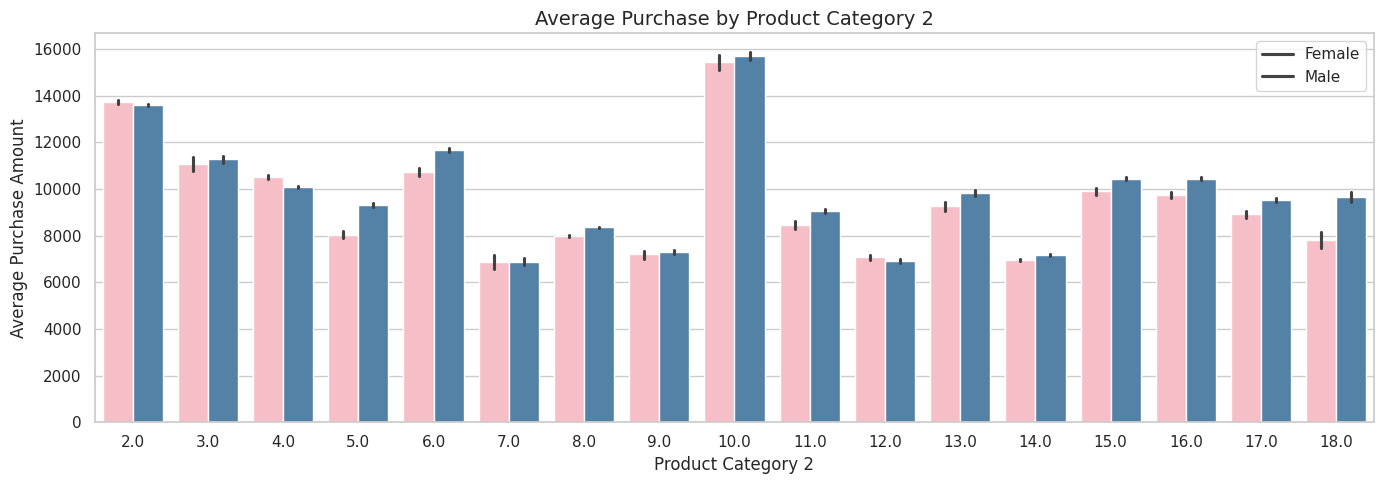

In [20]:
sns.barplot(x='Product_Category_2', y='Purchase', hue='Gender', palette=gender_palette, data=df)
plt.title('Average Purchase by Product Category 2', fontsize=14)
plt.xlabel('Product Category 2')
plt.ylabel('Average Purchase Amount')
plt.legend(labels=['Female', 'Male'])
plt.tight_layout()
plt.show()

### 5.5 Product Category 3 vs. Purchase

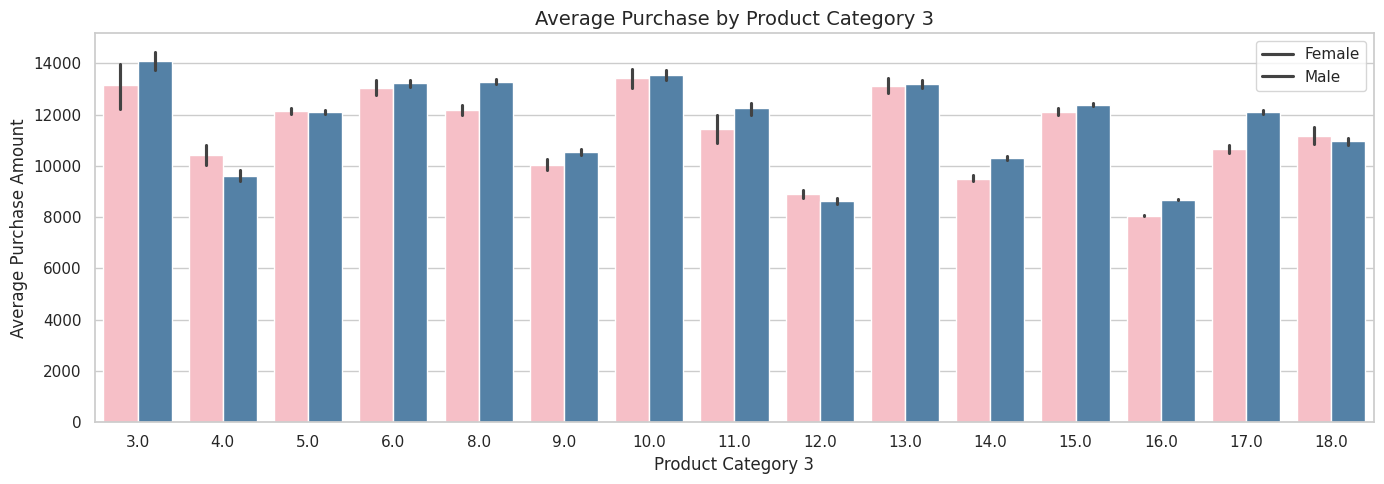

In [21]:
sns.barplot(x='Product_Category_3', y='Purchase', hue='Gender', palette=gender_palette, data=df)
plt.title('Average Purchase by Product Category 3', fontsize=14)
plt.xlabel('Product Category 3')
plt.ylabel('Average Purchase Amount')
plt.legend(labels=['Female', 'Male'])
plt.tight_layout()
plt.show()

## 6. Modelling — Purchase Amount Prediction

### 6.1 Prepare Features & Target
We split the merged dataset back into train rows (where Purchase is known) and prepare features/target.

In [22]:
# Use only rows with known Purchase (train set)
df_model = df[df['Purchase'].notna()].copy()

X = df_model.drop(columns=['Purchase', 'Product_ID'])
y = df_model['Purchase']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape : {y.shape}")
X.head(2)

Feature matrix shape: (550068, 10)
Target vector shape : (550068,)


,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,B,C
0,0,1,10,2,0,3,8.0,16.0,0,0
1,0,1,10,2,0,1,6.0,14.0,0,0


### 6.2 Train/Test Split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples : {X_train.shape[0]:,}")
print(f"Test samples     : {X_test.shape[0]:,}")

Training samples : 440,054
Test samples     : 110,014


### 6.3 Model 1 — Linear Regression
A simple baseline to understand how much variance a linear model can explain.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2   = r2_score(y_test, y_pred_lr)
lr_mae  = mean_absolute_error(y_test, y_pred_lr)

print("Linear Regression Results")
print(f"  MAE  : {lr_mae:,.2f}")
print(f"  RMSE : {lr_rmse:,.2f}")
print(f"  R²   : {lr_r2:.4f}")

Linear Regression Results
  MAE  : 3,575.52
  RMSE : 4,674.39
  R²   : 0.1304


### 6.4 Model 2 — Random Forest Regressor
An ensemble of decision trees — handles non-linearity and feature interactions well.

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2   = r2_score(y_test, y_pred_rf)

print("Random Forest Results")
print(f"  RMSE : {rf_rmse:,.2f}")
print(f"  R²   : {rf_r2:.4f}")

Random Forest Results
  RMSE : 3,051.65
  R²   : 0.6294


### 6.5 Model 3 — XGBoost Regressor
Gradient-boosted trees — typically strong on tabular data.

In [26]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2   = r2_score(y_test, y_pred_xgb)

print("XGBoost Results")
print(f"  RMSE : {xgb_rmse:,.2f}")
print(f"  R²   : {xgb_r2:.4f}")

XGBoost Results
  RMSE : 2,900.67
  R²   : 0.6651


### 6.6 Model Comparison

            Model        RMSE       R²
Linear Regression 4674.386591 0.130393
    Random Forest 3051.646032 0.629369
          XGBoost 2900.670724 0.665135


/tmp/ipykernel_2461/3443506921.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Model', y='RMSE', palette='Blues_d', ax=axes[0])
/tmp/ipykernel_2461/3443506921.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Model', y='R²', palette='Greens_d', ax=axes[1])


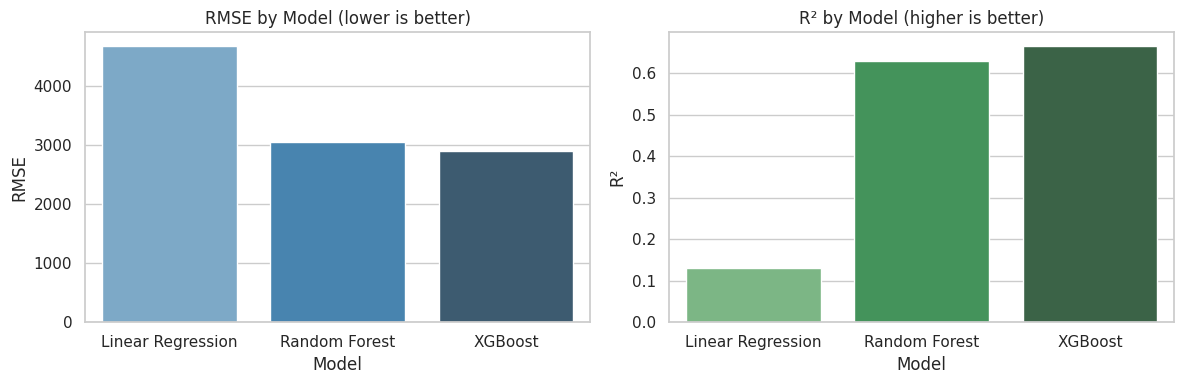

In [27]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE':  [lr_rmse, rf_rmse, xgb_rmse],
    'R²':    [lr_r2,   rf_r2,   xgb_r2]
})

print(results.to_string(index=False))

# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=results, x='Model', y='RMSE', palette='Blues_d', ax=axes[0])
axes[0].set_title('RMSE by Model (lower is better)')
sns.barplot(data=results, x='Model', y='R²', palette='Greens_d', ax=axes[1])
axes[1].set_title('R² by Model (higher is better)')
plt.tight_layout()
plt.show()

## 7. Conclusions & Key Takeaways

### Data Cleaning Summary
| Step | Action |
|------|--------|
| Dropped `User_ID` | Irrelevant identifier — no predictive value |
| Encoded `Gender` | Binary map: F→0, M→1 |
| Ordinal encoded `Age` | Preserved natural age ordering |
| One-hot encoded `City_Category` | Nominal variable — 2 dummy columns |
| Fixed `Stay_In_Current_City_Years` | Stripped `+`, cast to integer |
| Imputed `Product_Category_2 & 3` | Mode imputation for missing values |

### EDA Insights
- **Male customers dominate Black Friday spending** — consistently higher average purchase across all age groups and occupations.
- **Age group 26–35 spends the most**, consistent with peak earning and spending years.
- **Product Category 1 shows the widest purchase spread** — certain categories drive significantly higher spend.

### Modelling Results
- **Linear Regression** serves as a weak baseline — purchase behaviour is clearly non-linear.
- **Random Forest and XGBoost** substantially outperform the baseline.
- XGBoost is recommended for production use given its balance of accuracy and speed.
